In [26]:
import numpy as np
import scipy.stats as sp 
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
from pprint import pprint

<hr>
Set up datasets
<hr>

In [27]:
run_info =  {}

# Dir if on casper/cheyenne
run_info['run_root'] = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/' # LENS root directory
run_info['run_freq'] = 'monthly' #Frequency to analyze

# Dir if on CGD/thorodin
#run_info['run_root'] = '/project/mojave/cesm1/LENS/atm/' # LENS root directory
#run_info['run_freq'] = 'month_1' #Frequency to analyze




run_info['run_pref'] = 'b.e11.B20TRC5CNBDRD.f09_g16' #LENS File prefix
run_info['run_suff'] = '192001-200512' #File suffix
run_info['run_var'] = 'PRECT' #Variable
run_info['run_yrs'] =  (1950,2005) #First/last years to grab
run_info['run_period'] =  ('June','July','August','September','October') # Monthly to consider
run_info['run_ens'] = (2,10) # First and last ensemble member

run_info['run_reg'] = np.array([25,38,245,253]) # Lat/on  ranges for averaging
#run_info['run_reg'] = np.array([-15,15,120,160]) # Lat/on  ranges for averaging

<hr>
Loop Cases
<hr>

** ens num,name =  0 002
** ens num,name =  1 003
** ens num,name =  2 004
** ens num,name =  3 005
** ens num,name =  4 006
** ens num,name =  5 007
** ens num,name =  6 008
** ens num,name =  7 009
** ens num,name =  8 010


ValueError: 'line' is not a valid value for histtype; supported values are 'bar', 'barstacked', 'step', 'stepfilled'

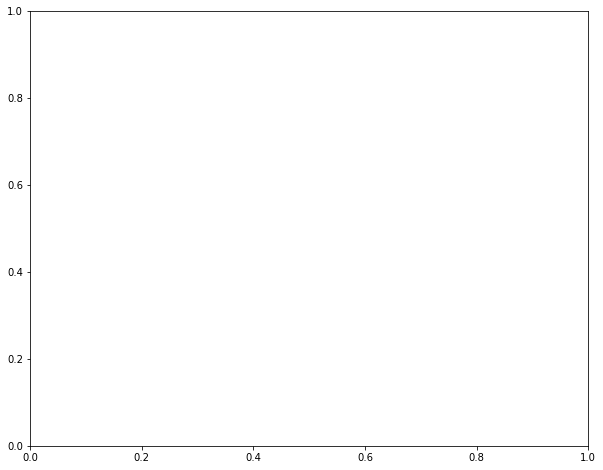

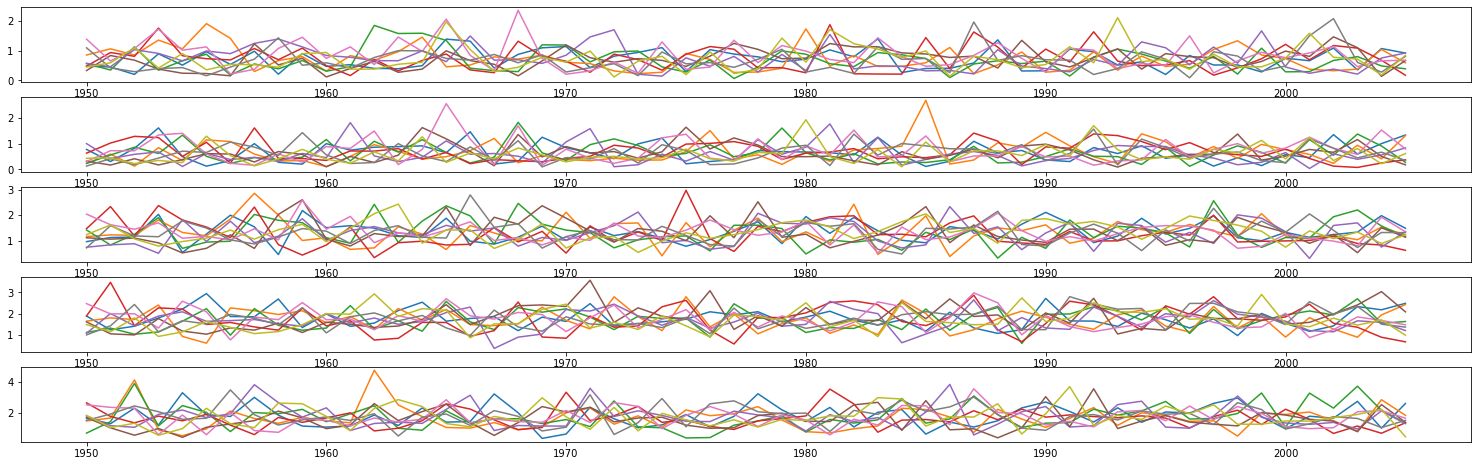

In [33]:
##################################
run_root = run_info['run_root']
run_freq = run_info['run_freq']
run_pref = run_info['run_pref']
run_var  = run_info['run_var']
run_ens  = run_info['run_ens']
run_suff  = run_info['run_suff']
run_yrs = run_info['run_yrs']
run_period = run_info['run_period']

run_reg = run_info['run_reg']

nmonths = len(run_period)
vscale = 86400*1000.

# Ensemble number/name array #
run_nums = np.arange(run_ens[0],run_ens[1]+1,1) # Wierdly needs run_ens+1
var_tav_ens = False

#var_tav_ens = None
fig, ax = mp.subplots(figsize=(10, 8))
fig_ts, ax_ts = mp.subplots(5,figsize=(26, 8))

### Loop Cases ###

for ir,rname in enumerate(run_nums):
   
    rname = '{:03}'.format(rname) # Format for ens# in LENS
    


    print('** ens num,name = ', ir,rname)
    
# Regional/temporal data selection

    if run_var=='PRECT':
        run_file_c = run_root+run_freq+'/PRECC/'+run_pref+'.'+str(rname)+'.cam.h0.PRECC.'+run_suff+'.nc'
        run_obj_c = xr.open_dataset(run_file_c,engine='netcdf4')
    
        run_file_l = run_root+run_freq+'/PRECL/'+run_pref+'.'+str(rname)+'.cam.h0.PRECL.'+run_suff+'.nc'
        run_obj_l = xr.open_dataset(run_file_l,engine='netcdf4')
        
        var_c = run_obj_c['PRECC'].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
        var_l = run_obj_l['PRECL'].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
        var = var_c+var_l
    else :
        run_file = run_root+run_freq+'/'+run_var+'/'+run_pref+'.'+str(rname)+'.cam.h0.'+run_var+'.'+run_suff+'.nc'
        run_obj = xr.open_dataset(run_file,engine='netcdf4')
        var = run_obj[run_var].loc[str(run_yrs[0]):str(run_yrs[1]),run_reg[0]:run_reg[1],run_reg[2]:run_reg[3]] 
    
    var = var*vscale
    
# Latitude (weighted) and longitude averaging
    gw_lat = np.cos(np.deg2rad(var.lat.values))  # Latitude weights
    var_av = (var * gw_lat[None, :, None]).sum(dim='lat') / np.sum(gw_lat)
    var_av = var_av.mean('lon')

# Time average (month or season)
    if ir==0:
        time = var.time # Read time
        months = time.dt.month # Array of months number
        mon_name = time.dt.strftime('%B') # Array of month names
        ptime = time.dt.year+(time.time.dt.month-1)/12 # Fraction of year (jan=0). x-axis on tseries plots
        pyear = time.dt.year # Just brab year array for tseries plots

# Tricky: extract tuple of arrays for points for
   
    if ir>0 : var_tav_prev = var_tav_tup # Set to previous value so we can append new run to this.
    var_tav_tup = () # Reset for this run
    
    for im in range(len(run_period)):
        im4ave = np.where(mon_name==run_period[im]) # Indices for this month
        var_tav = var_av[im4ave] # Values each year for this month
         
        ax_ts[im].plot(np.unique(pyear),var_tav) # Plot against just single years, for each month
        
        if ir==0 :
            var_tav_now = var_tav
        else :
            var_tav_now = np.concatenate((var_tav_prev[im],var_tav),axis=0)
                       
        var_tav_tup = var_tav_tup+(var_tav_now,) # Add to tuple for plotting
        
# PDF PLot using all runs.
num_bins = 20

ax.hist(var_tav_tup, num_bins, histtype='line', label = run_period)    
#ax.plot(var_tav_tup)

ax.legend()

#CDF too!

     
    
  

<hr>
Plotting
<hr>